In [3]:
# importing some required libraries
import pylab
from matplotlib import gridspec
from sklearn.datasets import make_classification
import numpy as np
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import pickle
import os
import gzip

# pick the seed for reproducability - change it to explore the effects of random variations
np.random.seed(1)
import random

In [4]:
# random classification dataset

n = 50
X, Y = make_classification(n_samples = n, n_features=2,                 #   X = array([[ 1.87972978e+00, -5.52650332e-01], ..., [ 7.25654045e-01,  1.07316293e+00]])
                           n_redundant=0, n_informative=2, flip_y=0)    #   Y = array([0, 1, 0, ..., 1, 1, 1])

Y = Y*2-1   # convert initial 0/1 values into -1/1

X = X.astype(np.float32);   # features - float
Y = Y.astype(np.int32)      # label - int

# Split the dataset into training and test
train_x, test_x = np.split(X, [ n*8//10])
train_labels, test_labels = np.split(Y, [n*8//10])

# train_x       = array([[-0.79132634,  0.928261  ], ..., [ 1.2227963 , -0.83539724]], dtype=float32)
# test_x        = array([[ 3.2197254 , -0.17890692], ..., [ 1.1982057 ,  0.9271133 ]], dtype=float32)  (much smaller)
# train_labels  = array([ 1,  1,  1, ..., 1,  1,  1])
# test_labels   = array([-1, -1,  1, ..., 1, -1, -1]))  (much smaller)

print("Features:\n",train_x[0:4])
print("Labels:\n",train_labels[0:4])


Features:
 [[-1.7441838  -1.3952037 ]
 [ 2.5921783  -0.08124504]
 [ 0.9218062   0.91789985]
 [-0.8437018  -0.18738253]]
Labels:
 [-1 -1  1 -1]


C:\Users\User\AppData\Local\Temp\ipykernel_5764\4274520564.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


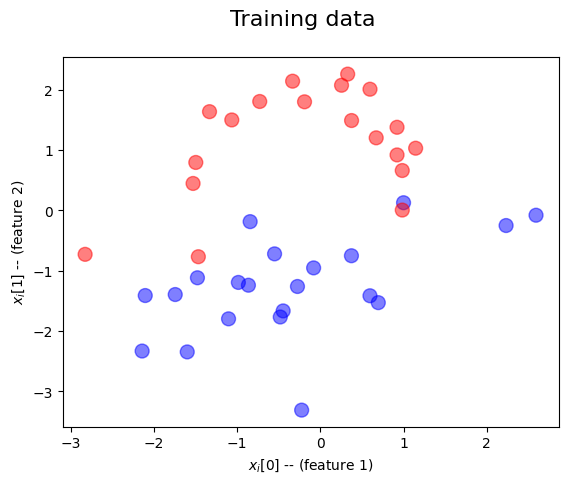

In [5]:
# Plots the dataset with features and labels.
def plot_dataset(suptitle, features, labels):
    
    # prepare the plot
    fig, ax = pylab.subplots(1, 1)  # fig = Figure(640x480) - ax = Axes(0.125,0.11;0.775x0.77)

    # pylab.subplots_adjust(bottom=0.2, wspace=0.4)
    fig.suptitle(suptitle, fontsize = 16)

    ax.set_xlabel('$x_i[0]$ -- (feature 1)')    # it writes the graphic's x and y labels (or titles)
    ax.set_ylabel('$x_i[1]$ -- (feature 2)')

    colors = ['r' if l>0 else 'b' for l in labels]

    # A scatter plot of *y* vs. *x* with varying marker size and/or color.
    ax.scatter(features[:, 0], features[:, 1], marker='o', c=colors, s=100, alpha = 0.5)    # s: shape size - alpha: the blending value
    fig.show()

plot_dataset('Training data', train_x, train_labels)

In [6]:
# A generic linear model should also have a bias, i.e. ideally we should compute as y = f((w^t)x)+b 
# To simplify our model, we can get rid of this bias term by adding one more dimension to our input features, which always equals to 1.

pos_examples = np.array([ [t[0], t[1], 1] for i,t in enumerate(train_x) 
                          if train_labels[i]>0])
neg_examples = np.array([ [t[0], t[1], 1] for i,t in enumerate(train_x) 
                          if train_labels[i]<0])
print(pos_examples[0:3])

[[ 0.92180622  0.91789985  1.        ]
 [-1.06435513  1.49764717  1.        ]
 [ 0.32839951  2.25677919  1.        ]]


In [7]:
# Training Algorithm

# Trains the model by adjusting the weights based on positive and negative examples.
def train(positive_examples, negative_examples, num_iterations = 100):
    num_dims = positive_examples.shape[1]   #  positive_examples.shape = (21, 3)
    
    # Initialize weights. 
    # We initialize with 0 for simplicity, but random initialization is also a good idea
    weights = np.zeros((num_dims,1))    # [[0.] [0.] [0.]]
    
    pos_count = positive_examples.shape[0]
    neg_count = negative_examples.shape[0]
    
    report_frequency = 10

    for i in range(num_iterations):
        # Pick one positive and one negative example
        pos = random.choice(positive_examples)
        neg = random.choice(negative_examples)

        z = np.dot(pos, weights)    # Dot product of two arrays
        if z < 0:   # positive example was classified as negative
            weights = weights + pos.reshape(weights.shape)

        z  = np.dot(neg, weights)
        if z >= 0:  # negative example was classified as positive
            weights = weights - neg.reshape(weights.shape)

        # Periodically, print out the current accuracy on all examples 
        if i % report_frequency == 0:             
            pos_out = np.dot(positive_examples, weights)
            neg_out = np.dot(negative_examples, weights)        
            pos_correct = (pos_out >= 0).sum() / float(pos_count)
            neg_correct = (neg_out < 0).sum() / float(neg_count)
            print("Iteration={}, pos correct={}, neg correct={}".format(i,pos_correct,neg_correct))
    
    return weights  # array([[0.40311285], [4.03908259], [0.        ]])


In [8]:
wts = train(pos_examples,neg_examples)
print(wts.transpose())

Iteration=0, pos correct=0.8421052631578947, neg correct=1.0
Iteration=10, pos correct=0.7894736842105263, neg correct=0.8095238095238095
Iteration=20, pos correct=0.7894736842105263, neg correct=0.9047619047619048
Iteration=30, pos correct=0.8421052631578947, neg correct=1.0
Iteration=40, pos correct=0.7894736842105263, neg correct=0.7619047619047619
Iteration=50, pos correct=0.9473684210526315, neg correct=0.7619047619047619
Iteration=60, pos correct=0.8947368421052632, neg correct=0.9523809523809523
Iteration=70, pos correct=0.9473684210526315, neg correct=0.9523809523809523
Iteration=80, pos correct=0.8947368421052632, neg correct=1.0
Iteration=90, pos correct=0.8421052631578947, neg correct=1.0
[[-0.97161412  4.76919815  0.        ]]


In [9]:
# visualizing how classes are separated
# Since we have only two dimensions x0 and x1, the equation for the line would be x0*w0+x1*w1+w2 =0 (remember that we have explicitly defined an extra dimension x2=1).
# plotting the line

# Plots the decision boundary that separates positive and negative examples.
def plot_boundary(positive_examples, negative_examples, weights):
    if np.isclose(weights[1], 0):   # Returns a boolean array where two arrays are element-wise equal within a tolerance.
        if np.isclose(weights[0], 0):
            x = y = np.array([-6, 6], dtype = 'float32')    # [-6.  6.]
        else:
            y = np.array([-6, 6], dtype='float32')
            x = -(weights[1] * y + weights[2])/weights[0]
    else:
        x = np.array([-6, 6], dtype='float32')
        y = -(weights[0] * x + weights[2])/weights[1]

    pylab.xlim(-6, 6)   # Get or set the x limits of the current axes.
    pylab.ylim(-6, 6)   

    pylab.plot(positive_examples[:,0], positive_examples[:,1], 'bo')
    pylab.plot(negative_examples[:,0], negative_examples[:,1], 'ro')
    pylab.plot(x, y, 'g', linewidth=2.0)
    
    pylab.show()


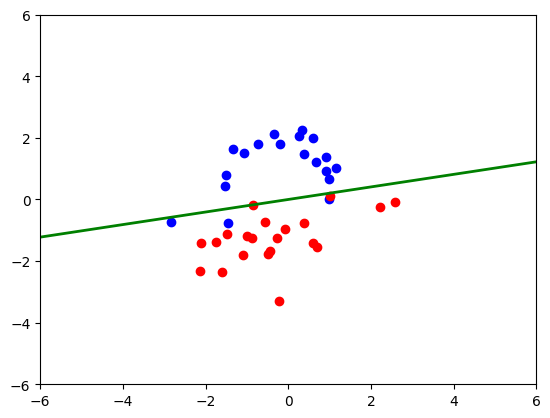

In [10]:
plot_boundary(pos_examples,neg_examples,wts)

In [11]:
# Evaluate on Test Dataset

# Computes the accuracy of the model on the test dataset.
def accuracy(weights, test_x, test_labels):
    res = np.dot(np.c_[test_x,np.ones(len(test_x))],weights)    # np.ones(...) returns a new array of given shape and type, filled with ones
    return (res.reshape(test_labels.shape)*test_labels>=0).sum()/float(len(test_labels))

accuracy(wts, test_x, test_labels)

1.0

In [12]:
# Observing the training process

# Trains a graph using the given positive and negative examples.
def train_graph(positive_examples, negative_examples, num_iterations = 100):
    num_dims = positive_examples.shape[1]   # positive_examples.shape = (19, 3) (num of shapes and their dimension) 
    weights = np.zeros((num_dims,1))    # initialize weights, weights = [[0.] [0.] [0.]]

    pos_count = positive_examples.shape[0]
    neg_count = negative_examples.shape[0]

    report_frequency = 15
    snapshots = []  # List to store snapshots of weights and accuracy

    for i in range(num_iterations):
        pos = random.choice(positive_examples)  # [-0.1901916   1.79802263  1.        ]
        neg = random.choice(negative_examples)  # [ 2.23235846 -0.2519221   1.        ]
        
        z = np.dot(pos, weights)    # [0.] 

        if z < 0:
            weights = weights + pos.reshape(weights.shape)  # weights.shape = (3, 1) - pos.shape = (3,) - pos.reshape(weights.shape) = [[1.14530575] [1.02912605] [1.        ]]
        
        z  = np.dot(neg, weights)

        if z >= 0:
            weights = weights - neg.reshape(weights.shape)
            
        if i % report_frequency == 0:             
            pos_out = np.dot(positive_examples, weights)
            neg_out = np.dot(negative_examples, weights)        
            pos_correct = (pos_out >= 0).sum() / float(pos_count)
            neg_correct = (neg_out < 0).sum() / float(neg_count)
            snapshots.append((np.copy(weights),(pos_correct+neg_correct)/2.0))
            
    return np.array(snapshots, list)
      
snapshots = train_graph(pos_examples,neg_examples)

# Plots the boundary and accuracy curve for a given step.
def plotit(pos_examples,neg_examples,snapshots,step):
    fig = pylab.figure(figsize=(10,4))  # figure(...): Creates a new figure, or activates an existing figure. - figsize: width, height in inches.
    fig.add_subplot(1, 2, 1)    # add_subplot(...): Adds an ~.axes.Axes to the figure as part of a subplot arrangement.
    plot_boundary(pos_examples, neg_examples, snapshots[step][0])   # snapshots[step] = [array([[-0.99987817],[-0.12590547],[-1.        ]]) 0.44110275689223055] - (0'th index is weights)
    fig.add_subplot(1, 2, 2)
    pylab.plot(np.arange(len(snapshots[:,1])), snapshots[:,1])  # Plotting the accuracy over iterations - np.arange(...): returns evenly spaced values within a given interval.
    pylab.ylabel('Accuracy')
    pylab.xlabel('Iteration')
    pylab.plot(step, snapshots[step,1], "bo")   # Marking the current step's accuracy with a blue dot
    pylab.show()

# Calls the plotit function with specified arguments.
def pl1(step):
    plotit(pos_examples,neg_examples,snapshots,step)


In [130]:
# Return a factory for interactive functions
interact(pl1, step=widgets.IntSlider(value=0, min=0, max=len(snapshots)-1))
# widgets: Provide simple interactive controls in the notebook. Each Widget corresponds to an object in Python and Javascript, with controls on the page.
# widgets.IntSlider: Slider widget that represents an integer bounded from above and below.


interactive(children=(IntSlider(value=0, description='step', max=6), Output()), _dom_classes=('widget-interact…

<function __main__.pl1(step)>

In [14]:
# Limitation Problem

# manually populate all positive and negative training samples
pos_examples_xor = np.array([[1,0,1],[0,1,1]])
neg_examples_xor = np.array([[1,1,1],[0,0,1]])

snapshots_xor = train_graph(pos_examples_xor,neg_examples_xor,1000)
def pl2(step):
    plotit(pos_examples_xor,neg_examples_xor,snapshots_xor,step)



In [15]:
interact(pl2, step=widgets.IntSlider(value=0, min=0, max=len(snapshots)-1))

interactive(children=(IntSlider(value=0, description='step', max=6), Output()), _dom_classes=('widget-interact…

<function __main__.pl2(step)>

In [46]:
# Complex Example - MNIST

# loading MNIST dataset

import sys

# If you are not running this notebook from a cloned repository, you may need to grab the binary dataset file first
# !wget https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true
# In this case correct the link to the dataset below as well.

# Open a gzip-compressed file in binary 
with gzip.open('mnist.pkl.gz', 'rb') as mnist_pickle:   
    # If the Python version is greater than 2, it uses the encoding='latin1' parameter when calling pickle.load()
    # In Python 3.x, the pickle module expects Unicode strings by default, and the 'latin1' encoding ensures that the binary data is loaded correctly.                              
    if sys.version_info.major > 2:
        MNIST = pickle.load(mnist_pickle, encoding='latin1')
    # If the Python version is 2.x or lower, the code falls back to the regular pickle.load() without specifying the encoding parameter.     
    else:          
        MNIST = pickle.load(mnist_pickle)

"""
MNIST = ((array([[0., 0., 0., ..., 0., 0., 0.], ..., [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([5, 0, 4, ..., 8, 4, 8], dtype=int64)),
        ...., 
        ((array([[0., 0., 0., ..., 0., 0., 0.], ..., [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([7, 2, 1, ..., 4, 5, 6], dtype=int64)))
"""


'\nMNIST = ((array([[0., 0., 0., ..., 0., 0., 0.], ..., [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([5, 0, 4, ..., 8, 4, 8], dtype=int64)),\n        ...., \n        ((array([[0., 0., 0., ..., 0., 0., 0.], ..., [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), array([7, 2, 1, ..., 4, 5, 6], dtype=int64)))\n'

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01171875 0.0703125
 0.0703125  0.0703125  0.4921875  0.53125    0.68359375 0.1015625
 0.6484375  0.99609375 0.96484375 0.49609375 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.1171875  0.140625
 0.3671875  0.6015625 ]
5


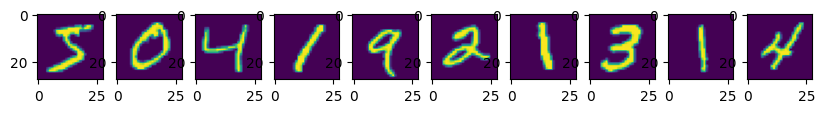

In [134]:
# plot the dataset

print(MNIST[0][0][0][130:180])  # MNIST['Train']['Features'][0][130:180]
print(MNIST[0][1][0])   # MNIST['Train']['Labels'][0]

features = MNIST[0][0].astype(np.float32) / 256.0   # array([[0., 0., 0., ..., 0., 0., 0.], ..., [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
labels = MNIST[0][1]    # array([5, 0, 4, ..., 8, 4, 8], dtype=int64)

fig = pylab.figure(figsize=(10,5))

for i in range(10):
    ax = fig.add_subplot(1,10,i+1)
    pylab.imshow(features[i].reshape(28,28))
pylab.show()

In [114]:
# Populates positive and negative sample arrays with two given digits (and also shows samples of those digits for clarity).
def set_mnist_pos_neg(positive_label, negative_label): 

    positive_indices = [i for i, j in enumerate(MNIST[0][1]) 
                          if j == positive_label]
    negative_indices = [i for i, j in enumerate(MNIST[0][1]) 
                          if j == negative_label]
    
    positive_images = MNIST[0][0][positive_indices]
    negative_images = MNIST[0][0][negative_indices]

    fig = pylab.figure()
    
    ax = fig.add_subplot(1, 2, 1)
    pylab.imshow(positive_images[0].reshape(28,28), cmap='gray', interpolation='nearest')   # 'gray': Grayscale colormap (shades of gray).
                                                                                            # 'nearest': Nearest-neighbor interpolation (pixelated display).
    ax.set_xticks([])   # removes axis indices
    ax.set_yticks([])

    ax = fig.add_subplot(1, 2, 2)
    pylab.imshow(negative_images[0].reshape(28,28), cmap='jet', interpolation='bilinear')   # 'jet': A classic colormap with a full spectrum of colors.
                                                                                            # 'bilinear': Bilinear interpolation (smooth blending of pixels).
    ax.set_xticks([])
    ax.set_yticks([])

    pylab.show()

    return positive_images, negative_images


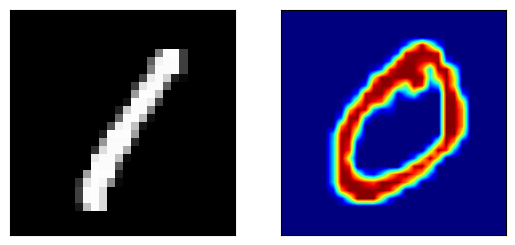

In [129]:
# classify between 0 and 1
pos1, neg1 = set_mnist_pos_neg(1,0) # pos1 = array([[0., 0., 0., ..., 0., 0., 0.], ..., [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
                                    # neg1 = array([[0., 0., 0., ..., 0., 0., 0.], ..., [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [146]:
snapshots_mn = train_graph(pos1,neg1,1000)    

# Returns a factory for interactive functions
interact(pl3, step=widgets.IntSlider(value=0, min=0, max=len(snapshots_mn) - 1))    # interact = interactive.factory()

# Accuracy goes up to almost 100% very fast.
# Weight matrix plotted on the left. 1's are positive, yellow parts represent ones,
# and the darker ones represent zeros, which are negative in our case

interactive(children=(IntSlider(value=0, description='step', max=66), Output()), _dom_classes=('widget-interac…

<function __main__.pl3(step)>

In [144]:
def plotit2(snapshots_mn,step):
    fig = pylab.figure(figsize=(10,4))
    ax = fig.add_subplot(1, 2, 1)
    pylab.imshow(snapshots_mn[step][0].reshape(28, 28), interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    pylab.colorbar()
    ax = fig.add_subplot(1, 2, 2)
    ax.set_ylim([0,1])  # Set the y-axis view limits.
    pylab.plot(np.arange(len(snapshots_mn[:,1])), snapshots_mn[:,1])    # np.arange(): Returns evenly spaced values within a given interval.
    pylab.plot(step, snapshots_mn[step,1], "bo")
    pylab.show()    # Display all open figures.

def pl3(step):
    plotit2(snapshots_mn,step)

def pl4(step):
    plotit2(snapshots_mn2,step) 


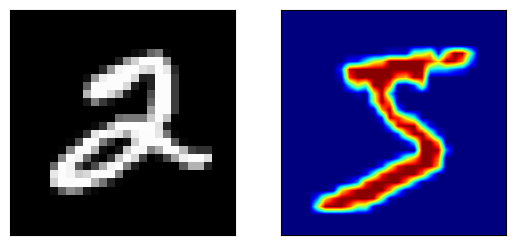

In [147]:
pos2,neg2 = set_mnist_pos_neg(2,5)

In [148]:
snapshots_mn2 = train_graph(pos2,neg2,1000)
interact(pl4, step=widgets.IntSlider(value=0, min=0, max=len(snapshots_mn2) - 1))

# Even though we get relatively high accuracy (above 85%), we can clearly see how perceptron stops learning at some point.

interactive(children=(IntSlider(value=0, description='step', max=66), Output()), _dom_classes=('widget-interac…

<function __main__.pl4(step)>